![banner](./imgs/banner.png)

# <center>Analyzes Spotify top 50 tracks in Brazil</center>

### Project Overview

This study analyzes the Top 50 most popular songs in Brazil on Spotify to understand the characteristics and patterns that define the current music landscape in the Brazilian market. The analysis focuses on available track metadata and artist information to provide insights into what makes a song successful in Brazil.

### Main Objectives

The primary goal of this project is to identify the key patterns and characteristics that influence music popularity in Brazil by examining the Top 50 tracks and uncovering trends in song attributes, artist collaborations, and content preferences that resonate with Brazilian audiences.

In [12]:
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
from datetime import date
import os
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

load_dotenv()
pd.set_option('display.max_columns', None)
pio.renderers.default = "png"
pio.defaults.default_width = 1200

### Authentication

In [13]:
# Params to generate token in Spotify API (Using .env variables)
url = ('https://accounts.spotify.com/api/token')
headers = {'Content-Type': 'application/x-www-form-urlencoded'}
payload = {'grant_type': 'client_credentials', 'client_id': os.environ["client_id"], 'client_secret': os.environ["client_secret"]}

#Generating and collecting token
r = requests.post(url, headers=headers, params=payload)
access_token = r.json().get('access_token')

### Data Collecting

In [14]:
# Params to collect data from playlist Top50-Brazil (2025-07-12)
url_busca = ('https://api.spotify.com/v1/playlists/5oKUZ4iFD04mtcuA8LTgma/tracks')
headers = {'Authorization': f'Bearer {access_token}'}
payload = {'limit': '50'}

#Collecting data
response = requests.get(url_busca, headers=headers, params=payload)
api_response = response.json()

Tip: I needed to clone the official playlist Top50-Brazil to my profile, because in the last Spotify API update, they changed the rules and now you can't collect data from official playlists.

In [15]:
tracks_data = []

In [16]:
# Transforming json in Dataframe
for item in api_response['items']:
        track = item['track']
        
        track_info = {
            'track_id': track.get('id'),
            'track_name': track.get('name'),
            'track_popularity': track.get('popularity'),
            'track_duration_ms': track.get('duration_ms'),
            'track_explicit': track.get('explicit'),
            'track_spotify_url': track.get('external_urls', {}).get('spotify'),
            'album_id': track.get('album', {}).get('id'),
            'album_name': track.get('album', {}).get('name'),
            'album_type': track.get('album', {}).get('album_type'),
            'album_release_date': track.get('album', {}).get('release_date'),
            'album_total_tracks': track.get('album', {}).get('total_tracks'),
            'artist_id': track.get('artists', [{}])[0].get('id') if track.get('artists') else None,
            'artist_name': track.get('artists', [{}])[0].get('name') if track.get('artists') else None,
            'total_available_markets': len(track.get('available_markets', []))
        }

        if track.get('artists'):
            all_artists = [artist.get('name') for artist in track.get('artists') if artist.get('name')]
            track_info['all_artists'] = ', '.join(all_artists)
        else:
            track_info['all_artists'] = None
            
        tracks_data.append(track_info)

df = pd.DataFrame(tracks_data)


In [17]:
df.head(3)

,track_id,track_name,track_popularity,track_duration_ms,track_explicit,track_spotify_url,album_id,album_name,album_type,album_release_date,album_total_tracks,artist_id,artist_name,total_available_markets,all_artists
0,7yRlmQTjZ5pdtlq7ska9mj,Artista Genérico,84,150861,True,https://open.spotify.com/track/7yRlmQTjZ5pdtlq...,21FP96bn6KdYTSe5zCbhZT,Eu Venci o Mundo,album,2025-06-26,16,4YqwRbMLqGHRHLS1w2ZKse,Veigh,185,"Veigh, Supernova Ent"
1,5Nj2UVsxXAvhfYNpcre3al,FAMOSINHA,88,132922,True,https://open.spotify.com/track/5Nj2UVsxXAvhfYN...,1hOcmOgX024gR2IkB7Xg26,FAMOSINHA,single,2025-02-28,1,4Kv35Xnw1ODjO2nIHLhdBY,Dj Caio Vieira,185,"Dj Caio Vieira, MC Meno K, Mc Rodrigo do CN"
2,7EknynLJTt9YMm1HL37s5D,P do Pecado - Ao Vivo,86,192367,False,https://open.spotify.com/track/7EknynLJTt9YMm1...,2JyYavPMFsaTRZFrc77bc3,P do Pecado (Ao Vivo),single,2025-04-29,1,6vTqEFbTtTRJsuIpzZgjxi,Grupo Menos É Mais,183,"Grupo Menos É Mais, Simone Mendes"


In [18]:
df.describe()

,track_popularity,track_duration_ms,album_total_tracks,total_available_markets
count,50.000000,50.000000,50.000000,50.000000
mean,80.540000,171790.020000,8.600000,183.800000
std,5.063716,50680.013476,7.431318,2.996597
min,69.000000,103727.000000,1.000000,164.000000
25%,78.000000,146867.750000,1.000000,183.000000
50%,80.500000,162580.000000,9.000000,185.000000
75%,83.750000,183630.750000,15.750000,185.000000
max,95.000000,459692.000000,28.000000,185.000000


### Exploratory Data Analysis

In [19]:
# Converting track duration from milliseconds to minutes
df['track_duration_min'] = (df['track_duration_ms'] / 60000).round(2)

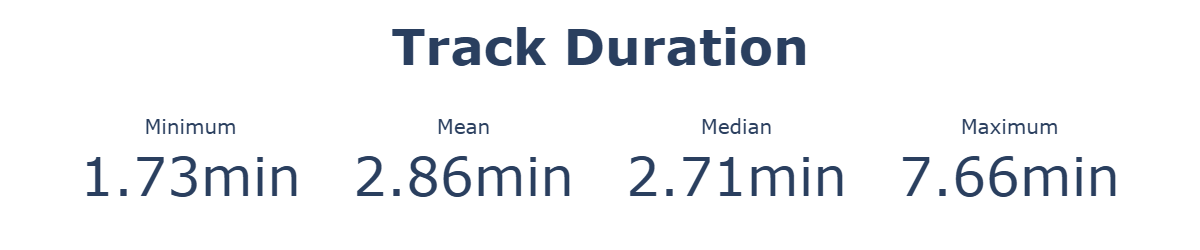

In [21]:
# Creating subplots to show indicators
duration_indicators = make_subplots(
    rows=1, cols=4,
    specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]]
)

# Creating indicators
duration_indicators.add_trace(go.Indicator(value=df['track_duration_min'].min(), number={'suffix': 'min', 'valueformat': '.2f'}, title='Minimum'), row=1, col=1)
duration_indicators.add_trace(go.Indicator(value=df['track_duration_min'].mean(), number={'suffix': 'min', 'valueformat': '.2f'}, title='Mean'), row=1, col=2)
duration_indicators.add_trace(go.Indicator(value=df['track_duration_min'].median(), number={'suffix': 'min', 'valueformat': '.2f'}, title='Median'), row=1, col=3)
duration_indicators.add_trace(go.Indicator(value=df['track_duration_min'].max(), number={'suffix': 'min', 'valueformat': '.2f'}, title='Maximum'), row=1, col=4)

# Updating layout with title and sizes
duration_indicators.update_layout(
    title_text="<b>Track Duration</b>", 
    title_font_size=50, 
    title_x=0.5, 
    height=250,
    margin=dict(t=130, b=30)
)

duration_indicators.show(height=250)

My first impression is that Brazilian popular music strongly social media formats. The data shows successful tracks cluster around 2.86 minutes (mean) and 2.71 minutes (median), indicating most popular songs stay within the 2.5-3 minute range for optimal streaming consumption.

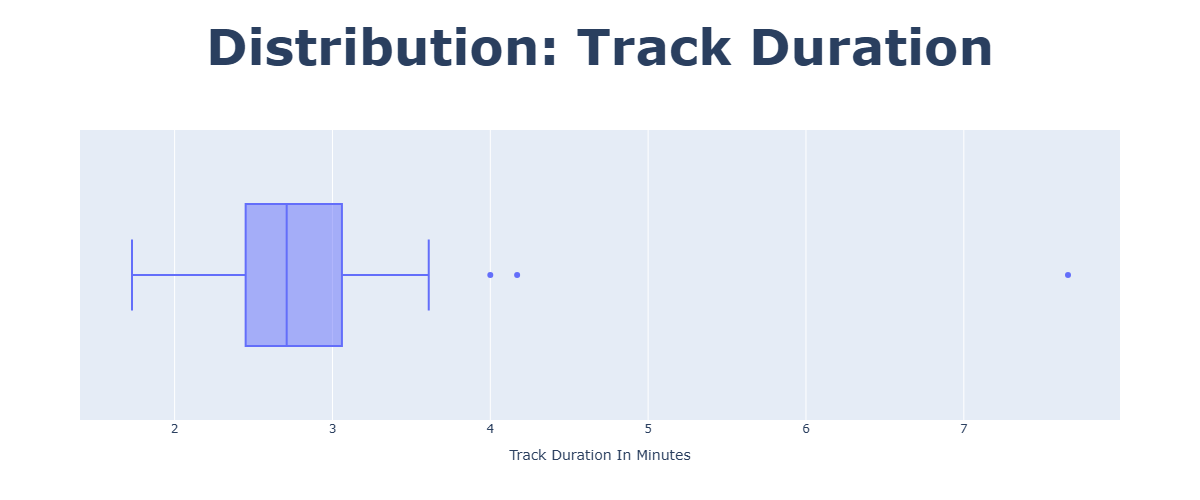

In [22]:
# Creating box chart
duration_box = px.box(df, x='track_duration_min')

# Updating layout with title and sizes
duration_box.update_layout(
    title_text="<b>Distribution: Track Duration</b>", 
    title_font_size=50, 
    title_x=0.5, 
    xaxis_title="Track Duration In Minutes", 
    margin=dict(t=130, b=80)
)

duration_box.show()

The box plot reveals that Brazilian Top 50 tracks follow a tight distribution pattern, with **75%** of songs falling between **2.45** and **3.06** minutes (Q1 to Q3). The upper fence at 3.61 minutes clearly defines the expected range for popular music, making any track longer than this an outlier in the Brazilian market.

Three notable outliers break this pattern at 4.0, 4.17, and 7.66 minutes, demonstrating that while longer tracks can occasionally achieve popularity, they represent exceptions rather than the rule. The compact interquartile range of just **0.61** minutes (3.06 - 2.45) confirms that successful Brazilian music follows a remarkably consistent duration formula, optimized for streaming platforms and audience attention spans.

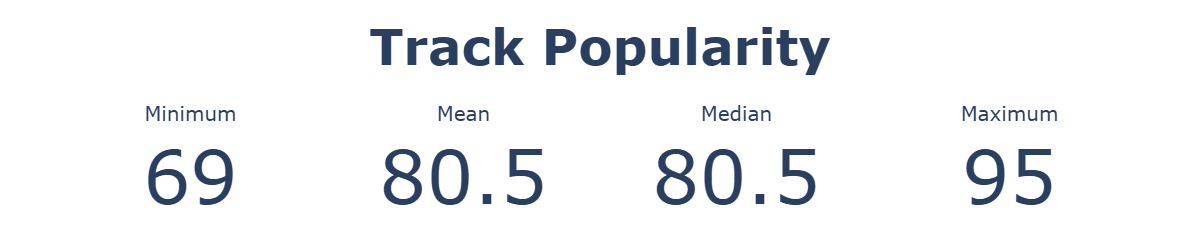

In [24]:
# Creating subplots to show indicators
popularity_indicators = make_subplots(
    rows=1, cols=4,
    specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]]
)

# Creating indicators
popularity_indicators.add_trace(go.Indicator(value=df['track_popularity'].min(), title="Minimum"), row=1, col=1)
popularity_indicators.add_trace(go.Indicator(value=df['track_popularity'].mean(), title="Mean"), row=1, col=2)
popularity_indicators.add_trace(go.Indicator(value=df['track_popularity'].median(), title="Median"), row=1, col=3)
popularity_indicators.add_trace(go.Indicator(value=df['track_popularity'].max(), title="Maximum"), row=1, col=4)

# Updating layout with title and sizes
popularity_indicators.update_layout(
    title_text="<b>Track Popularity</b>", 
    title_font_size=50, 
    title_x=0.5, 
    height=250, 
    margin=dict(t=130, b=30)
)

popularity_indicators.show(height=250)

The popularity scores show a concentrated range from 69 to 95 points, with perfect alignment between mean and median at 80.5, indicating a balanced distribution. This narrow 26-point range demonstrates that all tracks in Brazil's Top 50 maintain relatively high popularity scores, suggesting Spotify's ranking algorithm considers multiple factors beyond just popularity scores when determining chart positions.

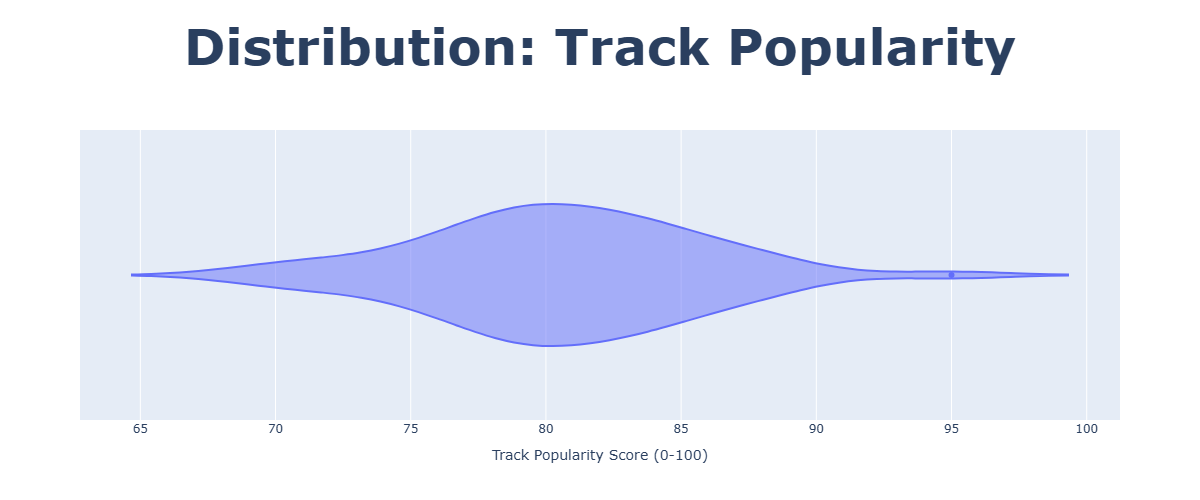

In [25]:
# Creating violin chart
popularity_violin = px.violin(df, x='track_popularity')

# Updating layout with title and sizes
popularity_violin.update_layout(
    title_text="<b>Distribution: Track Popularity</b>", 
    title_font_size=50, 
    title_x=0.5, 
    xaxis_title="Track Popularity Score (0-100)", 
    margin=dict(t=130, b=80)
)

popularity_violin.show()

The violin plot confirms the concentrated nature of popularity scores, with **75%** of tracks clustering between **78-84** points (Q1 to Q3).

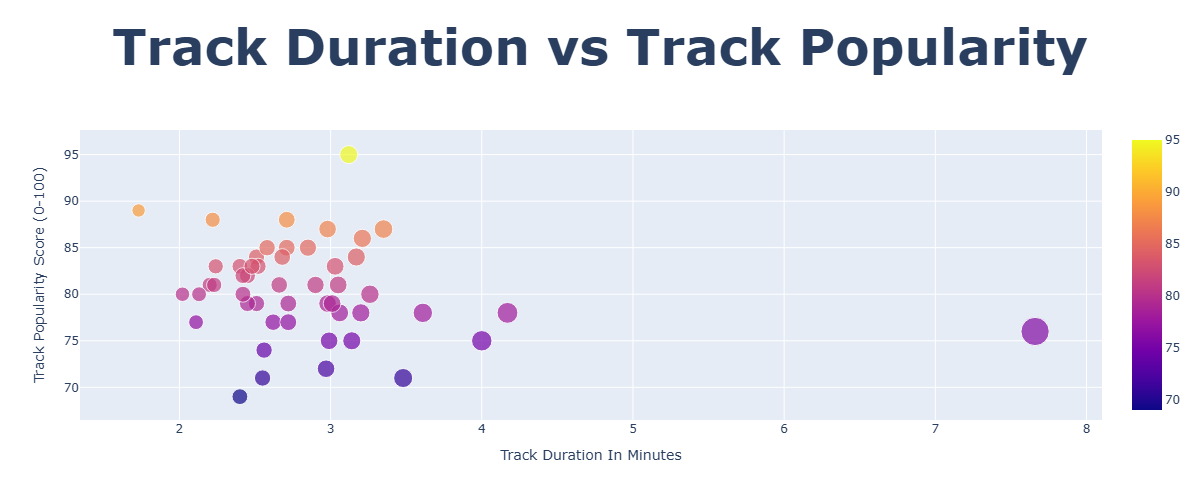

In [26]:
# Creating scatter chart
correlation_scatter = px.scatter(df, x="track_duration_min", y="track_popularity",size='track_duration_min', color='track_popularity')

# Updating layout with title and sizes
correlation_scatter.update_layout(
    title_text="<b>Track Duration vs Track Popularity</b>", 
    title_font_size=50, 
    title_x=0.5, 
    xaxis_title="Track Duration In Minutes", 
    yaxis_title="Track Popularity Score (0-100)", 
    coloraxis_colorbar=dict(title=""), 
    margin=dict(t=130, b=80)
)

correlation_scatter.show()

The scatter plot reveals a weak negative correlation between track duration and popularity, showing that shorter songs tend to achieve slightly higher popularity scores in Brazil's Top 50. Most successful tracks cluster in the 2-3.5 minute range with popularity scores of 75-90, forming the sweet spot for Brazilian popular music.

The three longer outliers (4+ minutes) display lower popularity scores, reinforcing that Brazilian audiences favor concise tracks. However, the correlation is relatively weak, indicating that while duration influences popularity, other factors play more significant roles in determining a song's success on the Brazilian charts.

In [27]:
# Setting variables to model
X = df[['track_duration_min']]
y = df['track_popularity']

# Doing linear regression
model = LinearRegression() 
model.fit(X, y)
y_pred = model.predict(X) 

# Getting R² and correlation
r2 = r2_score(y, y_pred)
correlation = X.iloc[:, 0].corr(y)

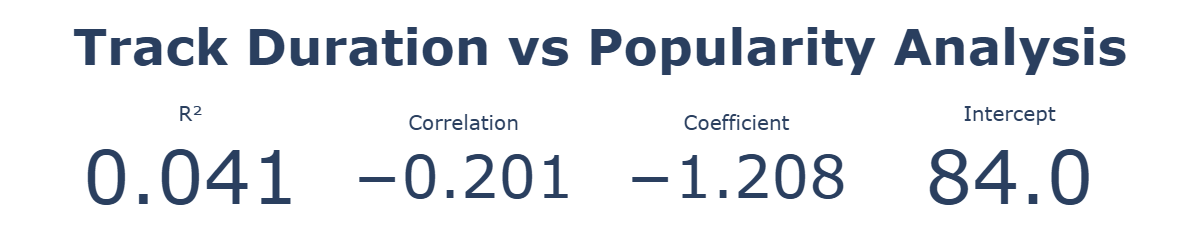

In [28]:
# Creating subplots to show indicators
regression_indicators = make_subplots(
    rows=1, 
    cols=4,
    specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]]
)

# Creating indicators
regression_indicators.add_trace(go.Indicator(value=r2, title="R²", mode="number", number={'valueformat': '.3f'}), row=1, col=1)
regression_indicators.add_trace(go.Indicator(value=correlation, title="Correlation", mode="number", number={'valueformat': '.3f'}), row=1, col=2)
regression_indicators.add_trace(go.Indicator(value=model.coef_[0], title="Coefficient", mode="number", number={'valueformat': '.3f'}), row=1, col=3)
regression_indicators.add_trace(go.Indicator(value=model.intercept_, title="Intercept", mode="number", number={'valueformat': '.1f'}), row=1, col=4)

# Updating layout with title and sizes
regression_indicators.update_layout(
    title_text="<b>Track Duration vs Popularity Analysis</b>", 
    title_font_size=50, 
    title_x=0.5, 
    height=250, 
    margin=dict(t=130, b=30)
)

regression_indicators.show(height=250)

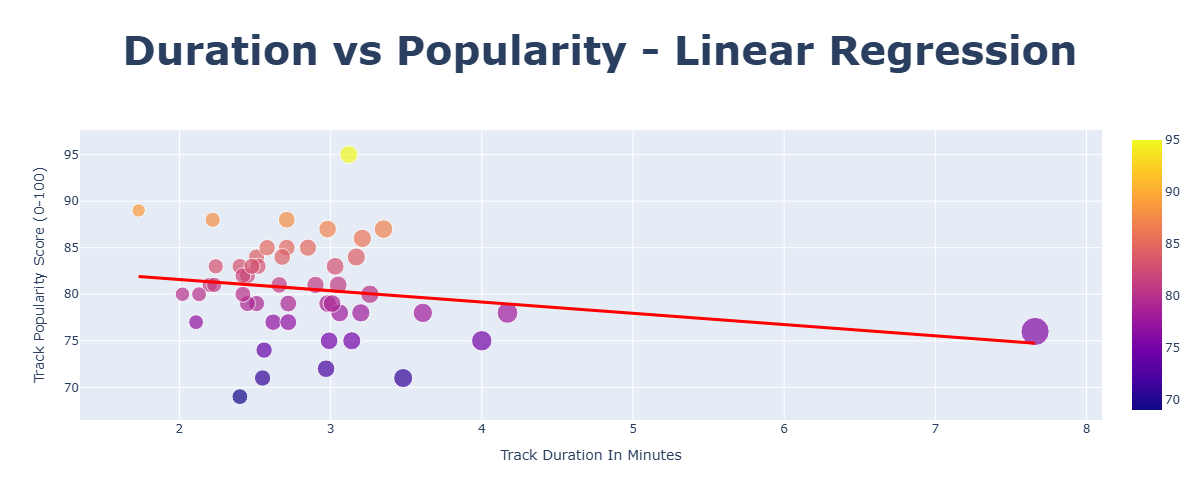

In [29]:
# Creating scatter chart
regression_scatter = px.scatter(df, x=X.iloc[:, 0], y=y,size=X.iloc[:, 0], color=y)

# Adding the linear regression line
regression_scatter.add_scatter(
    x=X.iloc[:, 0],
    y=y_pred,
    mode='lines',
    name='Linear Regression',
    line=dict(color='red', width=3)
)

# Updating layout with title and sizes
regression_scatter.update_layout(
    title_text="<b>Duration vs Popularity - Linear Regression</b>", 
    title_font_size=40, 
    title_x=0.5, 
    xaxis_title="Track Duration In Minutes", 
    yaxis_title="Track Popularity Score (0-100)", 
    coloraxis_colorbar=dict(title=""),
    showlegend=False,
    margin=dict(t=130, b=80)
)

regression_scatter.show()

The linear regression line confirms the negative correlation between track duration and popularity, showing a clear downward trend as song length increases. The regression line demonstrates that for every additional minute of song duration, there's a predictable decrease in popularity score, validating our earlier observation about Brazilian preferences for shorter tracks.

The relatively flat slope of the regression line indicates that while the correlation exists, it's moderate in strength. Most data points cluster around the regression line in the 2-3.5 minute range, suggesting that duration is a contributing factor to popularity but not the sole determinant of a track's success in Brazil's competitive music landscape.

In [30]:
# Tranforming column in datetime format
df['album_release_date'] = pd.to_datetime(df['album_release_date'])

# Getting the numbers of days since the launch date
df['period_launch'] = (pd.to_datetime(date.today()) - df['album_release_date']).dt.days

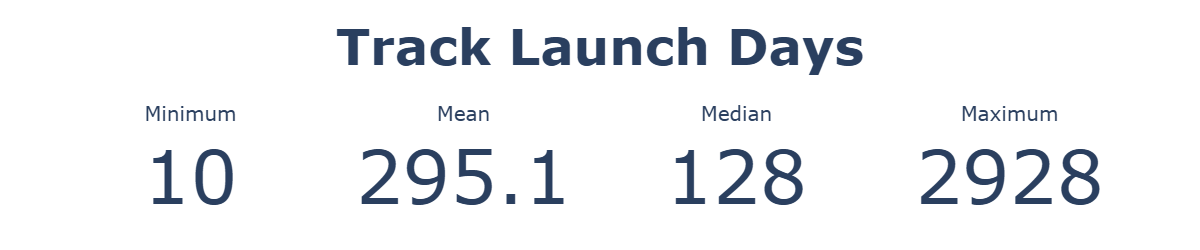

In [31]:
# Creating subplots to show indicators
release_indicators = make_subplots(
    rows=1, 
    cols=4,
    specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]]
)

# Creating indicators
release_indicators.add_trace(go.Indicator(value=df['period_launch'].min(), title="Minimum"), row=1, col=1)
release_indicators.add_trace(go.Indicator(value=df['period_launch'].mean(), title="Mean"), row=1, col=2)
release_indicators.add_trace(go.Indicator(value=df['period_launch'].median(), title="Median"), row=1, col=3)
release_indicators.add_trace(go.Indicator(value=df['period_launch'].max(), title="Maximum"), row=1, col=4)

# Updating layout with title and sizes
release_indicators.update_layout(
    title_text="<b>Track Launch Days</b>", 
    title_font_size=50, 
    title_x=0.5, 
    height=250, 
    margin=dict(t=130, b=30)
)

release_indicators.show(height=250)

The data reveals significant variation in how long tracks have been available, ranging from **10 days (minimum)** to **2,928 days (maximum)**, with a notable gap between **mean (295.1 days)** and **median (128 days)** indicating older tracks skewing the average upward. This pattern demonstrates that while fresh releases can quickly climb to Top 50 positions within just days, there's also remarkable staying power for certain tracks that maintain popularity over years, with the median of 128 days suggesting about half of Brazil's current top tracks achieved their position within roughly **4 months** of release.

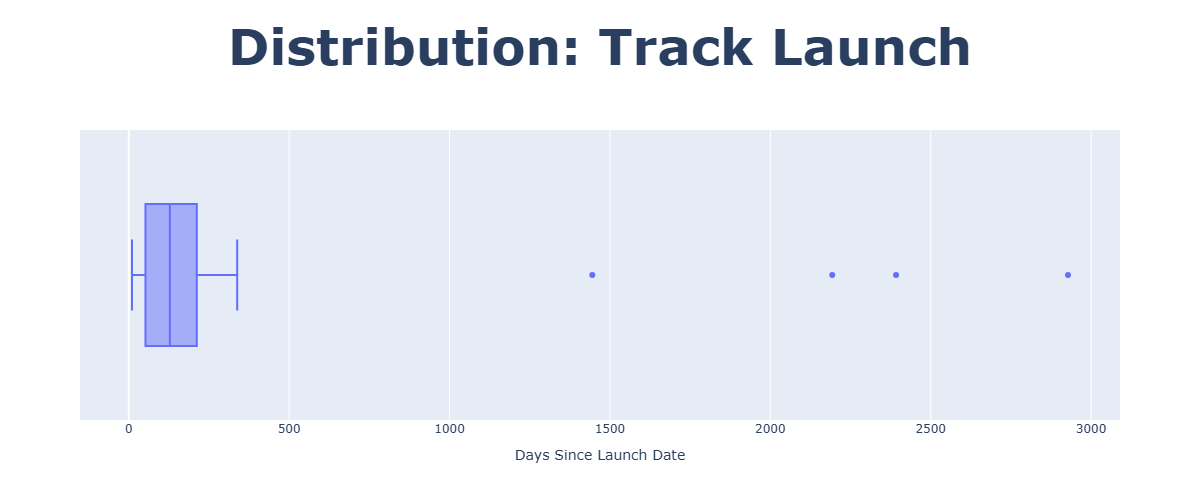

In [32]:
# Creating box chart
release_box = px.box(df, x='period_launch')

# Updating layout with title and sizes
release_box.update_layout(
    title_text="<b>Distribution: Track Launch</b>", 
    title_font_size=50, 
    title_x=0.5, 
    xaxis_title="Days Since Launch Date", 
    margin=dict(t=130, b=80)
)

release_box.show()

The box plot reveals that **75%** of tracks fall within a relatively narrow range of **52-212** days (Q1 to Q3) since their release. Four outliers at 1445, 2193, 2392, and 2928 days represent much older tracks that are currently in the Top 50, demonstrating that some songs can maintain or regain relevance years after their initial release in Brazil's music landscape.

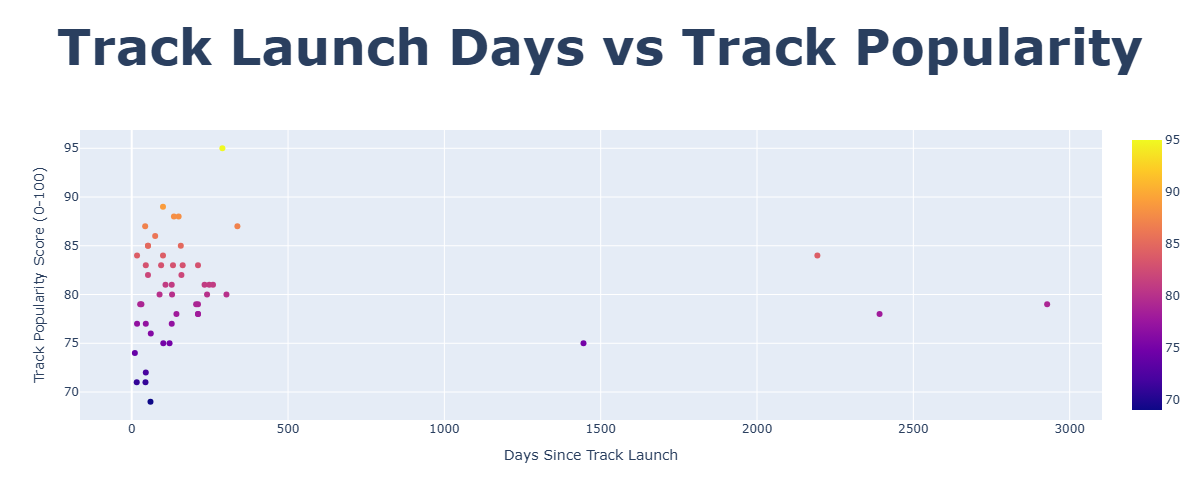

In [33]:
# Creating scatter chart
correlation_scatter = px.scatter(df, x="period_launch", y="track_popularity", color='track_popularity')

# Updating layout with title and sizes
correlation_scatter.update_layout(
    title_text="<b>Track Launch Days vs Track Popularity</b>", 
    title_font_size=50, 
    title_x=0.5, 
    xaxis_title="Days Since Track Launch", 
    yaxis_title="Track Popularity Score (0-100)", 
    coloraxis_colorbar=dict(title=""), 
    margin=dict(t=130, b=80)
)

correlation_scatter.show()

The scatter plot shows no clear correlation between a track's age and its current popularity score, with successful songs distributed across all timeframes from recent releases to tracks that are years old.

In [34]:
# Setting variables to model
X2 = df[['period_launch']]
y2 = df['track_popularity']

# Doing linear regression
model2 = LinearRegression() 
model2.fit(X2, y2)
y_pred2 = model2.predict(X2) 

# Getting R² and correlation
r2_2 = r2_score(y2, y_pred2)
correlation2 = X2.iloc[:, 0].corr(y2)

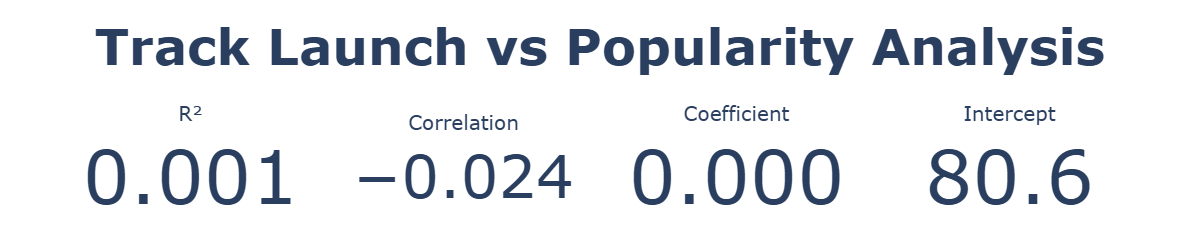

In [36]:
# Creating subplots to show indicators
regression_indicators2 = make_subplots(
    rows=1, 
    cols=4,
    specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]]
)

# Creating indicators
regression_indicators2.add_trace(go.Indicator(value=r2_2, title="R²", mode="number", number={'valueformat': '.3f'}), row=1, col=1)
regression_indicators2.add_trace(go.Indicator(value=correlation2, title="Correlation", mode="number", number={'valueformat': '.3f'}), row=1, col=2)
regression_indicators2.add_trace(go.Indicator(value=model2.coef_[0], title="Coefficient", mode="number", number={'valueformat': '.3f'}), row=1, col=3)
regression_indicators2.add_trace(go.Indicator(value=model2.intercept_, title="Intercept", mode="number", number={'valueformat': '.1f'}), row=1, col=4)

# Updating layout with title and sizes
regression_indicators2.update_layout(
    title_text="<b>Track Launch vs Popularity Analysis</b>", 
    title_font_size=50, 
    title_x=0.5, 
    height=250, 
    margin=dict(t=130, b=30)
)

regression_indicators2.show(height=250)

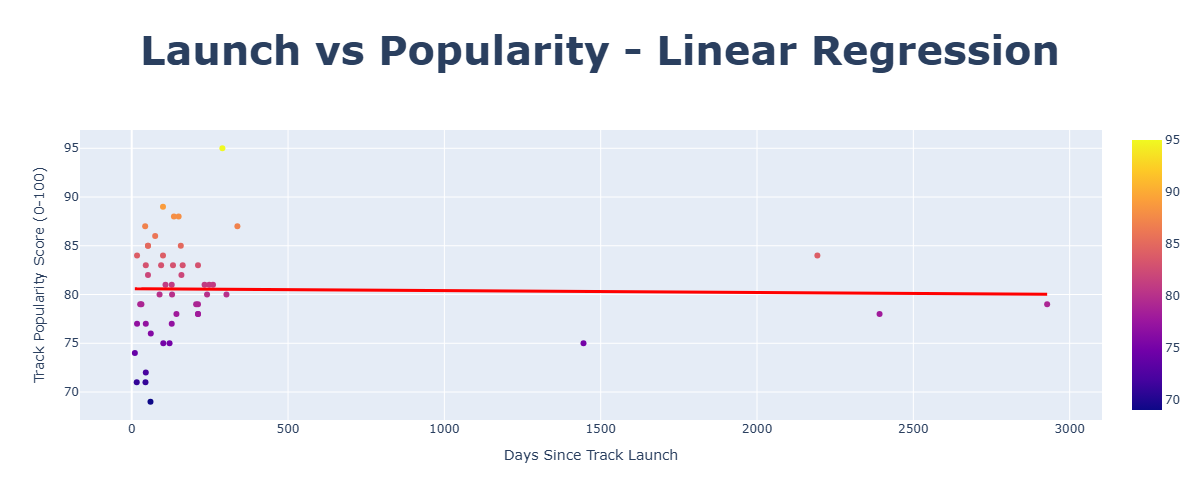

In [37]:
# Creating scatter chart
regression2_scatter = px.scatter(df, x=X2.iloc[:, 0], y=y2, color=y2)

# Adding the linear regression line
regression2_scatter.add_scatter(
    x=X2.iloc[:, 0],
    y=y_pred2,
    mode='lines',
    name='Linear Regression',
    line=dict(color='red', width=3)
)

# Updating layout with title and sizes
regression2_scatter.update_layout(
    title_text="<b>Launch vs Popularity - Linear Regression</b>", 
    title_font_size=40, 
    title_x=0.5, 
    xaxis_title="Days Since Track Launch", 
    yaxis_title="Track Popularity Score (0-100)", 
    coloraxis_colorbar=dict(title=""),
    showlegend=False,
    margin=dict(t=130, b=80)
)

regression2_scatter.show()

The linear regression line confirms the **absence of meaningful correlation** between track age and popularity, displaying an almost perfectly flat horizontal trend around the 80-point popularity mark. This validates that a song's time since release has virtually no predictive power over its current popularity score in Brazil's Top 50, reinforcing that track quality, cultural relevance, and other factors far outweigh release timing in determining chart success.

In [38]:
# Mapping explicit and no-explicit tracks
df['track_explicit'] = df['track_explicit'].map({
    True: 'Explicits', 
    False: 'No-Explicits'
})

In [39]:
# Counting the quantity of explicit tracks
tracks_explicit = df['track_explicit'].value_counts()

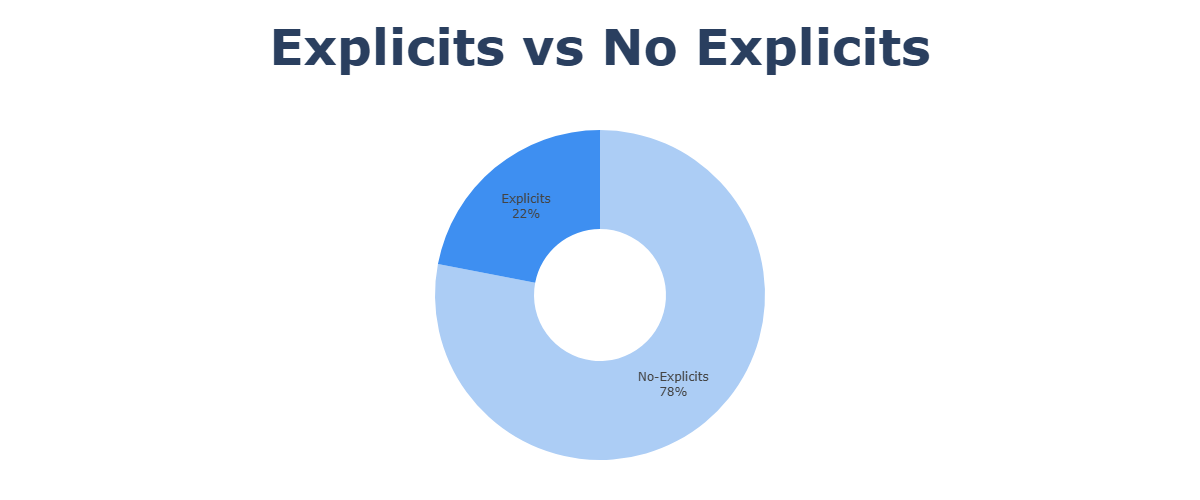

In [40]:
# Creating donut chart
explicit_pie = px.pie(values=tracks_explicit.values, names=tracks_explicit.index, hole=0.4, color_discrete_sequence=['#accdf5', '#3e8ff1'])

# Adjusting the labels
explicit_pie.update_traces(
    textposition='inside',
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Quantity: %{value}<br>Percent: %{percent}<extra></extra>'
)

# Updating layout with title and sizes
explicit_pie.update_layout(
    showlegend=False,
    title_text='<b>Explicits vs No Explicits</b>',
    title_font_size=50, 
    title_x=0.5,
    margin=dict(t=130, b=40)
)
explicit_pie.show()

The donut chart reveals that 78% of Brazil's Top 50 tracks are non-explicit, while only 22% contain explicit content. This distribution suggests that Brazilian audiences predominantly favor clean content, or that explicit tracks face certain barriers in achieving mainstream popularity, possibly due to radio play restrictions or broader market preferences that favor family-friendly music in the country's most popular charts.

In [41]:
# Getting top 5 artists with more tracks
top_5_artists = df['artist_name'].value_counts().head(5).index.tolist()

# Creating a dataframe with only top 5
df_top5 = df[df['artist_name'].isin(top_5_artists)]

# Grouping dataframe to use in sunburst chart
sunburst_data = df_top5.groupby(['artist_name', 'track_name']).size().reset_index(name='count')

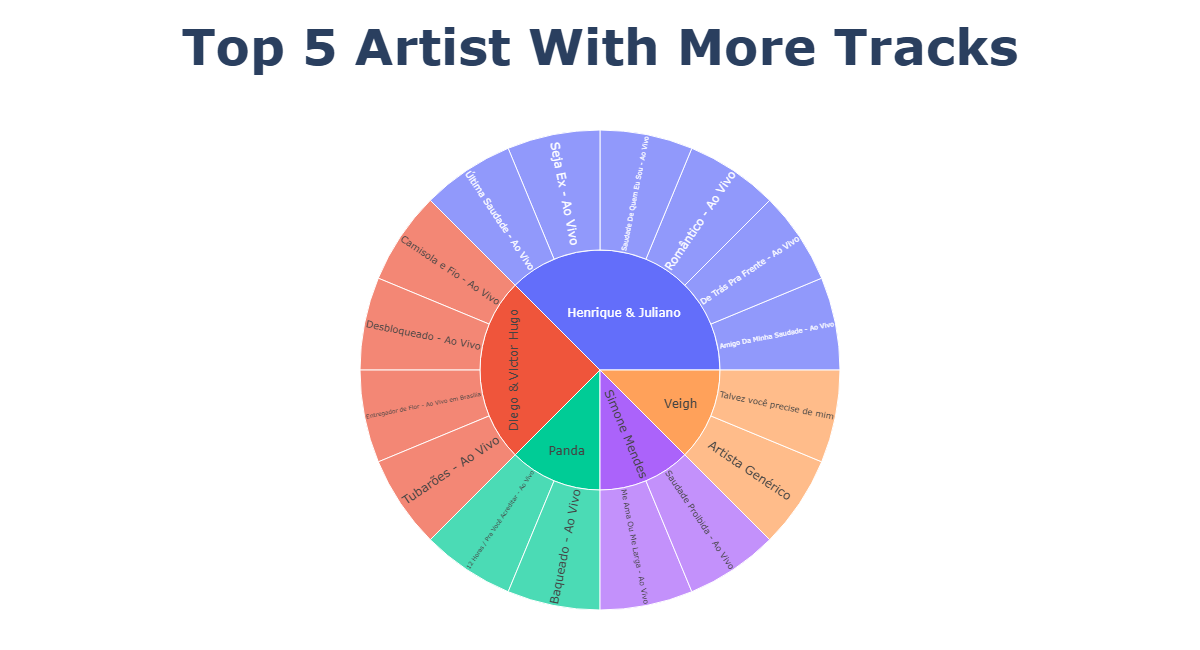

In [43]:
# Creating sunburst chart
sunburst = px.sunburst(sunburst_data, path=['artist_name', 'track_name'])

# Updating layout with title and sizes
sunburst.update_layout(
    height=650,
    title_text='<b>Top 5 Artist With More Tracks</b>',
    title_font_size=50, 
    title_x=0.5,
    margin=dict(t=130, b=40)
)
sunburst.show(height=650)

The sunburst chart reveals Henrique & Juliano as the dominant force in Brazil's Top 50, with these top 5 artists demonstrating remarkable chart penetration by placing multiple tracks simultaneously. This concentration highlights how established artists with strong fan bases can achieve multiple chart positions, showcasing the power of artist loyalty in Brazil's competitive music market.

In [44]:
# Getting the number of artirst per track
df['num_artists'] = df['all_artists'].str.count(',') + 1

In [45]:
# Setting variables to model
X3 = df[['num_artists']]
y3 = df['track_popularity']

# Doing linear regression
model3 = LinearRegression()
model3.fit(X3, y3)
y_pred3 = model3.predict(X3)

# Getting R² and correlation
r2_3 = r2_score(y3, y_pred3)
correlation3 = X3.iloc[:, 0].corr(y3)

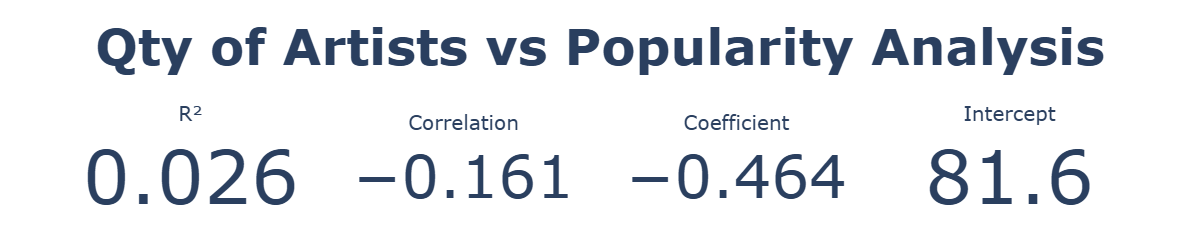

In [46]:
# Creating subplots to show indicators
regression_indicators3 = make_subplots(
    rows=1, 
    cols=4,
    specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}]]
)

# Creating indicators
regression_indicators3.add_trace(go.Indicator(value=r2_3, title="R²", mode="number", number={'valueformat': '.3f'}), row=1, col=1)
regression_indicators3.add_trace(go.Indicator(value=correlation3, title="Correlation", mode="number", number={'valueformat': '.3f'}), row=1, col=2)
regression_indicators3.add_trace(go.Indicator(value=model3.coef_[0], title="Coefficient", mode="number", number={'valueformat': '.3f'}), row=1, col=3)
regression_indicators3.add_trace(go.Indicator(value=model3.intercept_, title="Intercept", mode="number", number={'valueformat': '.1f'}), row=1, col=4)

# Updating layout with title and sizes
regression_indicators3.update_layout(
    title_text="<b>Qty of Artists vs Popularity Analysis</b>", 
    title_font_size=50, 
    title_x=0.5, 
    height=250, 
    margin=dict(t=130, b=30)
)

regression_indicators3.show(height=250)

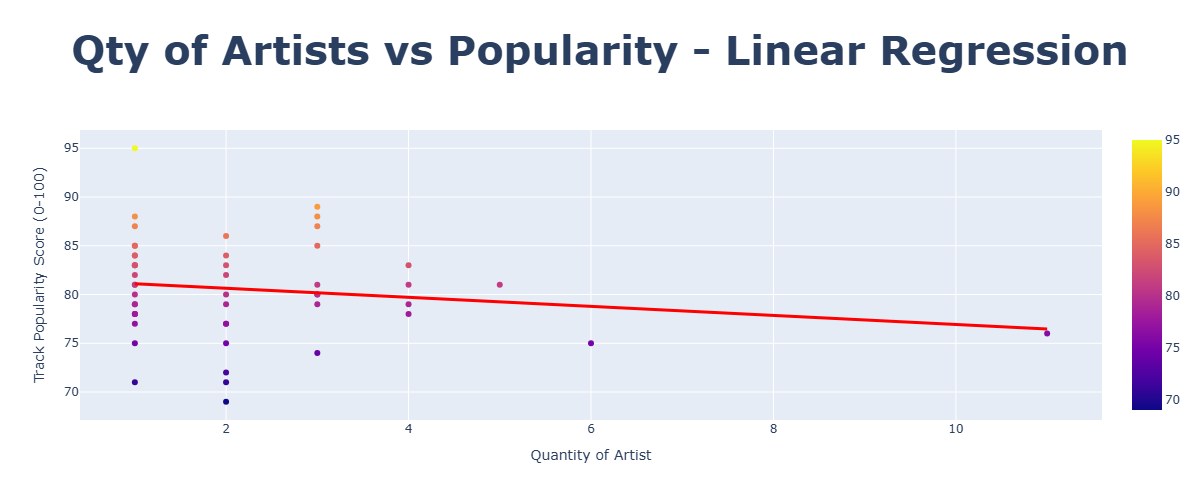

In [47]:
# Creating scatter chart
regression3_scatter = px.scatter(df, x=X3.iloc[:, 0], y=y3, color=y3)

# Adding the linear regression line
regression3_scatter.add_scatter(
    x=X3.iloc[:, 0],
    y=y_pred3,
    mode='lines',
    name='Linear Regression',
    line=dict(color='red', width=3)
)

# Updating layout with title and sizes
regression3_scatter.update_layout(
    title_text="<b>Qty of Artists vs Popularity - Linear Regression</b>", 
    title_font_size=40, 
    title_x=0.5, 
    xaxis_title="Quantity of Artist", 
    yaxis_title="Track Popularity Score (0-100)", 
    coloraxis_colorbar=dict(title=""),
    showlegend=False,
    margin=dict(t=130, b=80)
)

regression3_scatter.show()

The nearly flat regression line confirms no meaningful correlation between artist quantity and popularity scores, with both solo tracks and collaborations achieving similar success ranges (70-95 points). This demonstrates that collaboration quantity doesn't determine chart success in Brazil's Top 50, where song quality matters more than artist count.